In [ ]:
# Will Koehrsen
# Start Here: A Gentle Introduction
# https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

In [50]:
import pandas as pd
import numpy as np
import catboost as cat
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from catboost import CatBoostClassifier, cv, Pool
from sklearn.metrics import mean_squared_error

In [2]:
app_train = pd.read_csv('/Users/pliu/Downloads/credit/application_train.csv')
app_test = pd.read_csv('/Users/pliu/Downloads/credit/application_test.csv')

In [7]:
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

In [4]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
all_data.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

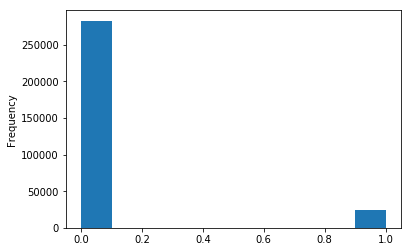

In [9]:
# distribution of target var
app_train['TARGET'].astype(int).plot.hist();
# findings: imbalaned dataset

In [12]:
# concat data
all_data = pd.concat((app_train.loc[:, 'NAME_CONTRACT_TYPE':'AMT_REQ_CREDIT_BUREAU_YEAR'],
                     app_test.loc[:, 'NAME_CONTRACT_TYPE':'AMT_REQ_CREDIT_BUREAU_YEAR']))
# concat vertically
all_data.shape
all_data.reset_index(drop=True, inplace=True)

In [13]:
# Missing value statistics
def missing_data(df=all_data):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data = missing_data()
missing_data.head(20)

,Total,Percent
COMMONAREA_MEDI,248360,0.697141
COMMONAREA_AVG,248360,0.697141
COMMONAREA_MODE,248360,0.697141
NONLIVINGAPARTMENTS_MODE,246861,0.692933
NONLIVINGAPARTMENTS_MEDI,246861,0.692933
NONLIVINGAPARTMENTS_AVG,246861,0.692933
FONDKAPREMONT_MODE,243092,0.682354
LIVINGAPARTMENTS_MEDI,242979,0.682037
LIVINGAPARTMENTS_MODE,242979,0.682037
LIVINGAPARTMENTS_AVG,242979,0.682037


In [15]:
all_data.shape

(356255, 121)

In [14]:
# create a col to record missing value per row before missing value processing
all_data['missing_per_row'] = all_data.isnull().sum(axis=1)
all_data['missing_per_row'].value_counts()

48    52116
49    48374
1     29403
2     27519
50    24379
47    19569
3     15276
0     10341
56     8983
55     8730
17     7515
18     7179
8      5609
9      5387
19     4691
4      4668
24     4367
57     4191
20     3774
23     3723
10     3546
25     3499
21     3468
16     3196
5      3190
22     3070
7      2893
26     2825
54     2603
27     2365
      ...  
11     1906
29     1890
51     1882
30     1822
31     1629
12     1602
13     1349
14     1313
32     1170
33     1142
40     1119
15     1094
34     1009
41      979
39      744
35      718
36      636
37      630
46      629
42      546
38      463
43      284
44      251
45      209
53      195
52      179
58       34
59       27
60       20
61       10
Name: missing_per_row, Length: 62, dtype: int64

In [17]:
# overview of categorical var (dtype=object)
# num of unique classes in each object column
all_data.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [20]:
cat_var = all_data.select_dtypes(include=['object']).columns

In [26]:
cat_data = all_data[cat_var]
cat_data.shape

(356255, 16)

In [41]:
all_data.select_dtypes('object').apply(lambda x: sum(pd.isnull(x))).sort_values(ascending=False)

FONDKAPREMONT_MODE            243092
WALLSMATERIAL_MODE            180234
HOUSETYPE_MODE                177916
EMERGENCYSTATE_MODE           167964
OCCUPATION_TYPE               111996
NAME_TYPE_SUITE                 2203
ORGANIZATION_TYPE                  0
WEEKDAY_APPR_PROCESS_START         0
NAME_HOUSING_TYPE                  0
NAME_FAMILY_STATUS                 0
NAME_EDUCATION_TYPE                0
NAME_INCOME_TYPE                   0
FLAG_OWN_REALTY                    0
FLAG_OWN_CAR                       0
CODE_GENDER                        0
NAME_CONTRACT_TYPE                 0
dtype: int64

In [42]:
all_data_ori = all_data.copy()

In [43]:
# fillna by -999, catboost would be able to identify that
all_data.fillna(-999,inplace=True)
all_data.isnull().sum()

NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
OWN_CAR_AGE                    0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
OCCUPATION_TYPE                0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
          

In [45]:
train, test = all_data[:len(app_train)], all_data[len(app_train):]
train.shape

(307511, 121)

In [46]:
y = app_train.TARGET

In [47]:
# extract categorical features
cate_feature_index = np.where((train.dtypes != int) & (train.dtypes != float ))[0]
cate_feature_index

array([ 0,  1,  2,  3,  9, 10, 11, 12, 13, 26, 30, 38, 84, 85, 87, 88])

In [49]:
# make train and validation set
xtrain, xvalidation, ytrain, yvalidation = train_test_split(train,y,train_size=.85,random_state=1)

/miniconda3/envs/ml36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [51]:
# Train Model
print ('Train CatBoost Decision Tree')
modelstart = time.time()
model = CatBoostClassifier(iterations=2000,
                          learning_rate=0.05,
                          depth=7,
                          eval_metric="AUC")
model.fit(xtrain, ytrain,
          eval_set=(xvalidation,yvalidation),
          cat_features=cate_feature_index,
          use_best_model=True,
          verbose=True)

Train CatBoost Decision Tree
0:	test: 0.7201429	best: 0.7201429 (0)	total: 868ms	remaining: 28m 54s
1:	test: 0.7277729	best: 0.7277729 (1)	total: 1.72s	remaining: 28m 33s
2:	test: 0.7291933	best: 0.7291933 (2)	total: 2.51s	remaining: 27m 51s
3:	test: 0.7322872	best: 0.7322872 (3)	total: 3.32s	remaining: 27m 38s
4:	test: 0.7324853	best: 0.7324853 (4)	total: 4.15s	remaining: 27m 37s
5:	test: 0.7325520	best: 0.7325520 (5)	total: 4.93s	remaining: 27m 19s
6:	test: 0.7333799	best: 0.7333799 (6)	total: 5.7s	remaining: 27m 2s
7:	test: 0.7353889	best: 0.7353889 (7)	total: 6.51s	remaining: 27m 2s
8:	test: 0.7355160	best: 0.7355160 (8)	total: 7.3s	remaining: 26m 55s
9:	test: 0.7372675	best: 0.7372675 (9)	total: 8.13s	remaining: 26m 58s
10:	test: 0.7399698	best: 0.7399698 (10)	total: 8.91s	remaining: 26m 50s
11:	test: 0.7403013	best: 0.7403013 (11)	total: 9.69s	remaining: 26m 45s
12:	test: 0.7413506	best: 0.7413506 (12)	total: 10.5s	remaining: 26m 40s
13:	test: 0.7416241	best: 0.7416241 (13)	total

113:	test: 0.7600460	best: 0.7600460 (113)	total: 1m 37s	remaining: 26m 57s
114:	test: 0.7601607	best: 0.7601607 (114)	total: 1m 38s	remaining: 26m 57s
115:	test: 0.7602426	best: 0.7602426 (115)	total: 1m 39s	remaining: 26m 59s
116:	test: 0.7602504	best: 0.7602504 (116)	total: 1m 40s	remaining: 26m 55s
117:	test: 0.7602751	best: 0.7602751 (117)	total: 1m 41s	remaining: 26m 51s
118:	test: 0.7603478	best: 0.7603478 (118)	total: 1m 41s	remaining: 26m 51s
119:	test: 0.7603791	best: 0.7603791 (119)	total: 1m 42s	remaining: 26m 47s
120:	test: 0.7604207	best: 0.7604207 (120)	total: 1m 43s	remaining: 26m 50s
121:	test: 0.7604531	best: 0.7604531 (121)	total: 1m 44s	remaining: 26m 50s
122:	test: 0.7605524	best: 0.7605524 (122)	total: 1m 45s	remaining: 26m 47s
123:	test: 0.7605266	best: 0.7605524 (122)	total: 1m 46s	remaining: 26m 45s
124:	test: 0.7606098	best: 0.7606098 (124)	total: 1m 46s	remaining: 26m 41s
125:	test: 0.7606498	best: 0.7606498 (125)	total: 1m 47s	remaining: 26m 43s
126:	test: 0

222:	test: 0.7633582	best: 0.7633582 (222)	total: 3m 3s	remaining: 24m 24s
223:	test: 0.7633698	best: 0.7633698 (223)	total: 3m 4s	remaining: 24m 23s
224:	test: 0.7633540	best: 0.7633698 (223)	total: 3m 5s	remaining: 24m 21s
225:	test: 0.7634909	best: 0.7634909 (225)	total: 3m 5s	remaining: 24m 19s
226:	test: 0.7635020	best: 0.7635020 (226)	total: 3m 6s	remaining: 24m 17s
227:	test: 0.7635209	best: 0.7635209 (227)	total: 3m 7s	remaining: 24m 15s
228:	test: 0.7635292	best: 0.7635292 (228)	total: 3m 8s	remaining: 24m 14s
229:	test: 0.7635422	best: 0.7635422 (229)	total: 3m 8s	remaining: 24m 12s
230:	test: 0.7635400	best: 0.7635422 (229)	total: 3m 9s	remaining: 24m 12s
231:	test: 0.7635460	best: 0.7635460 (231)	total: 3m 10s	remaining: 24m 10s
232:	test: 0.7635494	best: 0.7635494 (232)	total: 3m 11s	remaining: 24m 8s
233:	test: 0.7635675	best: 0.7635675 (233)	total: 3m 11s	remaining: 24m 6s
234:	test: 0.7635905	best: 0.7635905 (234)	total: 3m 12s	remaining: 24m 4s
235:	test: 0.7635731	bes

331:	test: 0.7648449	best: 0.7648616 (330)	total: 4m 39s	remaining: 23m 25s
332:	test: 0.7648231	best: 0.7648616 (330)	total: 4m 40s	remaining: 23m 24s
333:	test: 0.7648224	best: 0.7648616 (330)	total: 4m 41s	remaining: 23m 22s
334:	test: 0.7648560	best: 0.7648616 (330)	total: 4m 41s	remaining: 23m 20s
335:	test: 0.7648927	best: 0.7648927 (335)	total: 4m 42s	remaining: 23m 19s
336:	test: 0.7648930	best: 0.7648930 (336)	total: 4m 43s	remaining: 23m 17s
337:	test: 0.7649130	best: 0.7649130 (337)	total: 4m 43s	remaining: 23m 15s
338:	test: 0.7649159	best: 0.7649159 (338)	total: 4m 44s	remaining: 23m 14s
339:	test: 0.7649070	best: 0.7649159 (338)	total: 4m 45s	remaining: 23m 12s
340:	test: 0.7649164	best: 0.7649164 (340)	total: 4m 45s	remaining: 23m 10s
341:	test: 0.7649461	best: 0.7649461 (341)	total: 4m 46s	remaining: 23m 9s
342:	test: 0.7649758	best: 0.7649758 (342)	total: 4m 47s	remaining: 23m 9s
343:	test: 0.7649711	best: 0.7649758 (342)	total: 4m 48s	remaining: 23m 7s
344:	test: 0.76

440:	test: 0.7657984	best: 0.7658015 (439)	total: 6m 8s	remaining: 21m 43s
441:	test: 0.7658175	best: 0.7658175 (441)	total: 6m 9s	remaining: 21m 42s
442:	test: 0.7658460	best: 0.7658460 (442)	total: 6m 10s	remaining: 21m 40s
443:	test: 0.7658974	best: 0.7658974 (443)	total: 6m 10s	remaining: 21m 39s
444:	test: 0.7659701	best: 0.7659701 (444)	total: 6m 11s	remaining: 21m 37s
445:	test: 0.7659762	best: 0.7659762 (445)	total: 6m 12s	remaining: 21m 36s
446:	test: 0.7659838	best: 0.7659838 (446)	total: 6m 12s	remaining: 21m 34s
447:	test: 0.7660182	best: 0.7660182 (447)	total: 6m 13s	remaining: 21m 33s
448:	test: 0.7660029	best: 0.7660182 (447)	total: 6m 14s	remaining: 21m 32s
449:	test: 0.7660336	best: 0.7660336 (449)	total: 6m 14s	remaining: 21m 30s
450:	test: 0.7660593	best: 0.7660593 (450)	total: 6m 15s	remaining: 21m 29s
451:	test: 0.7660570	best: 0.7660593 (450)	total: 6m 16s	remaining: 21m 28s
452:	test: 0.7660664	best: 0.7660664 (452)	total: 6m 16s	remaining: 21m 26s
453:	test: 0.7

549:	test: 0.7665741	best: 0.7665757 (547)	total: 7m 20s	remaining: 19m 22s
550:	test: 0.7665532	best: 0.7665757 (547)	total: 7m 21s	remaining: 19m 20s
551:	test: 0.7665406	best: 0.7665757 (547)	total: 7m 22s	remaining: 19m 19s
552:	test: 0.7665798	best: 0.7665798 (552)	total: 7m 22s	remaining: 19m 18s
553:	test: 0.7665691	best: 0.7665798 (552)	total: 7m 23s	remaining: 19m 17s
554:	test: 0.7665803	best: 0.7665803 (554)	total: 7m 24s	remaining: 19m 16s
555:	test: 0.7665883	best: 0.7665883 (555)	total: 7m 24s	remaining: 19m 15s
556:	test: 0.7665869	best: 0.7665883 (555)	total: 7m 25s	remaining: 19m 14s
557:	test: 0.7665791	best: 0.7665883 (555)	total: 7m 26s	remaining: 19m 13s
558:	test: 0.7665692	best: 0.7665883 (555)	total: 7m 26s	remaining: 19m 11s
559:	test: 0.7665632	best: 0.7665883 (555)	total: 7m 27s	remaining: 19m 10s
560:	test: 0.7665547	best: 0.7665883 (555)	total: 7m 28s	remaining: 19m 9s
561:	test: 0.7665290	best: 0.7665883 (555)	total: 7m 28s	remaining: 19m 8s
562:	test: 0.7

658:	test: 0.7669550	best: 0.7670012 (649)	total: 8m 33s	remaining: 17m 25s
659:	test: 0.7669569	best: 0.7670012 (649)	total: 8m 34s	remaining: 17m 23s
660:	test: 0.7669639	best: 0.7670012 (649)	total: 8m 34s	remaining: 17m 22s
661:	test: 0.7669629	best: 0.7670012 (649)	total: 8m 35s	remaining: 17m 21s
662:	test: 0.7669606	best: 0.7670012 (649)	total: 8m 36s	remaining: 17m 20s
663:	test: 0.7669664	best: 0.7670012 (649)	total: 8m 36s	remaining: 17m 19s
664:	test: 0.7669750	best: 0.7670012 (649)	total: 8m 37s	remaining: 17m 18s
665:	test: 0.7669721	best: 0.7670012 (649)	total: 8m 37s	remaining: 17m 17s
666:	test: 0.7669915	best: 0.7670012 (649)	total: 8m 38s	remaining: 17m 16s
667:	test: 0.7669706	best: 0.7670012 (649)	total: 8m 39s	remaining: 17m 15s
668:	test: 0.7669740	best: 0.7670012 (649)	total: 8m 39s	remaining: 17m 14s
669:	test: 0.7669958	best: 0.7670012 (649)	total: 8m 40s	remaining: 17m 13s
670:	test: 0.7669953	best: 0.7670012 (649)	total: 8m 41s	remaining: 17m 12s
671:	test: 0

767:	test: 0.7674635	best: 0.7674635 (767)	total: 9m 46s	remaining: 15m 41s
768:	test: 0.7674589	best: 0.7674635 (767)	total: 9m 47s	remaining: 15m 40s
769:	test: 0.7674443	best: 0.7674635 (767)	total: 9m 48s	remaining: 15m 39s
770:	test: 0.7674387	best: 0.7674635 (767)	total: 9m 48s	remaining: 15m 38s
771:	test: 0.7674483	best: 0.7674635 (767)	total: 9m 49s	remaining: 15m 37s
772:	test: 0.7674531	best: 0.7674635 (767)	total: 9m 50s	remaining: 15m 36s
773:	test: 0.7674606	best: 0.7674635 (767)	total: 9m 50s	remaining: 15m 35s
774:	test: 0.7674636	best: 0.7674636 (774)	total: 9m 51s	remaining: 15m 34s
775:	test: 0.7674625	best: 0.7674636 (774)	total: 9m 52s	remaining: 15m 33s
776:	test: 0.7674647	best: 0.7674647 (776)	total: 9m 52s	remaining: 15m 32s
777:	test: 0.7674583	best: 0.7674647 (776)	total: 9m 53s	remaining: 15m 32s
778:	test: 0.7674768	best: 0.7674768 (778)	total: 9m 54s	remaining: 15m 31s
779:	test: 0.7674666	best: 0.7674768 (778)	total: 9m 54s	remaining: 15m 30s
780:	test: 0

875:	test: 0.7678599	best: 0.7678735 (872)	total: 11m	remaining: 14m 7s
876:	test: 0.7678508	best: 0.7678735 (872)	total: 11m 1s	remaining: 14m 6s
877:	test: 0.7678467	best: 0.7678735 (872)	total: 11m 2s	remaining: 14m 6s
878:	test: 0.7678596	best: 0.7678735 (872)	total: 11m 2s	remaining: 14m 5s
879:	test: 0.7678723	best: 0.7678735 (872)	total: 11m 3s	remaining: 14m 4s
880:	test: 0.7678743	best: 0.7678743 (880)	total: 11m 4s	remaining: 14m 3s
881:	test: 0.7678623	best: 0.7678743 (880)	total: 11m 4s	remaining: 14m 2s
882:	test: 0.7678563	best: 0.7678743 (880)	total: 11m 5s	remaining: 14m 1s
883:	test: 0.7678342	best: 0.7678743 (880)	total: 11m 6s	remaining: 14m
884:	test: 0.7678297	best: 0.7678743 (880)	total: 11m 6s	remaining: 14m
885:	test: 0.7678681	best: 0.7678743 (880)	total: 11m 7s	remaining: 13m 59s
886:	test: 0.7678221	best: 0.7678743 (880)	total: 11m 8s	remaining: 13m 58s
887:	test: 0.7678117	best: 0.7678743 (880)	total: 11m 9s	remaining: 13m 57s
888:	test: 0.7678467	best: 0.76

983:	test: 0.7680725	best: 0.7680990 (979)	total: 12m 14s	remaining: 12m 38s
984:	test: 0.7680825	best: 0.7680990 (979)	total: 12m 15s	remaining: 12m 37s
985:	test: 0.7680775	best: 0.7680990 (979)	total: 12m 16s	remaining: 12m 37s
986:	test: 0.7680955	best: 0.7680990 (979)	total: 12m 16s	remaining: 12m 36s
987:	test: 0.7681099	best: 0.7681099 (987)	total: 12m 17s	remaining: 12m 35s
988:	test: 0.7681229	best: 0.7681229 (988)	total: 12m 18s	remaining: 12m 34s
989:	test: 0.7681080	best: 0.7681229 (988)	total: 12m 18s	remaining: 12m 33s
990:	test: 0.7681309	best: 0.7681309 (990)	total: 12m 19s	remaining: 12m 32s
991:	test: 0.7681471	best: 0.7681471 (991)	total: 12m 20s	remaining: 12m 32s
992:	test: 0.7681549	best: 0.7681549 (992)	total: 12m 20s	remaining: 12m 31s
993:	test: 0.7681593	best: 0.7681593 (993)	total: 12m 21s	remaining: 12m 30s
994:	test: 0.7681495	best: 0.7681593 (993)	total: 12m 22s	remaining: 12m 29s
995:	test: 0.7681627	best: 0.7681627 (995)	total: 12m 22s	remaining: 12m 28s

1088:	test: 0.7682985	best: 0.7683228 (1055)	total: 13m 27s	remaining: 11m 15s
1089:	test: 0.7682976	best: 0.7683228 (1055)	total: 13m 27s	remaining: 11m 14s
1090:	test: 0.7682991	best: 0.7683228 (1055)	total: 13m 28s	remaining: 11m 13s
1091:	test: 0.7683099	best: 0.7683228 (1055)	total: 13m 29s	remaining: 11m 12s
1092:	test: 0.7683162	best: 0.7683228 (1055)	total: 13m 29s	remaining: 11m 11s
1093:	test: 0.7682965	best: 0.7683228 (1055)	total: 13m 30s	remaining: 11m 11s
1094:	test: 0.7682906	best: 0.7683228 (1055)	total: 13m 31s	remaining: 11m 10s
1095:	test: 0.7682675	best: 0.7683228 (1055)	total: 13m 31s	remaining: 11m 9s
1096:	test: 0.7682645	best: 0.7683228 (1055)	total: 13m 32s	remaining: 11m 8s
1097:	test: 0.7682688	best: 0.7683228 (1055)	total: 13m 33s	remaining: 11m 8s
1098:	test: 0.7682975	best: 0.7683228 (1055)	total: 13m 34s	remaining: 11m 7s
1099:	test: 0.7683228	best: 0.7683228 (1099)	total: 13m 34s	remaining: 11m 6s
1100:	test: 0.7683280	best: 0.7683280 (1100)	total: 13m 3

1193:	test: 0.7681770	best: 0.7683790 (1136)	total: 14m 39s	remaining: 9m 53s
1194:	test: 0.7681875	best: 0.7683790 (1136)	total: 14m 39s	remaining: 9m 52s
1195:	test: 0.7681803	best: 0.7683790 (1136)	total: 14m 40s	remaining: 9m 51s
1196:	test: 0.7681704	best: 0.7683790 (1136)	total: 14m 41s	remaining: 9m 51s
1197:	test: 0.7681768	best: 0.7683790 (1136)	total: 14m 41s	remaining: 9m 50s
1198:	test: 0.7681809	best: 0.7683790 (1136)	total: 14m 42s	remaining: 9m 49s
1199:	test: 0.7681908	best: 0.7683790 (1136)	total: 14m 43s	remaining: 9m 48s
1200:	test: 0.7681926	best: 0.7683790 (1136)	total: 14m 43s	remaining: 9m 47s
1201:	test: 0.7681742	best: 0.7683790 (1136)	total: 14m 44s	remaining: 9m 47s
1202:	test: 0.7681593	best: 0.7683790 (1136)	total: 14m 45s	remaining: 9m 46s
1203:	test: 0.7681586	best: 0.7683790 (1136)	total: 14m 45s	remaining: 9m 45s
1204:	test: 0.7681551	best: 0.7683790 (1136)	total: 14m 46s	remaining: 9m 44s
1205:	test: 0.7681416	best: 0.7683790 (1136)	total: 14m 47s	rema

1299:	test: 0.7682620	best: 0.7683790 (1136)	total: 15m 50s	remaining: 8m 32s
1300:	test: 0.7682679	best: 0.7683790 (1136)	total: 15m 51s	remaining: 8m 31s
1301:	test: 0.7682832	best: 0.7683790 (1136)	total: 15m 52s	remaining: 8m 30s
1302:	test: 0.7682815	best: 0.7683790 (1136)	total: 15m 53s	remaining: 8m 29s
1303:	test: 0.7682648	best: 0.7683790 (1136)	total: 15m 53s	remaining: 8m 29s
1304:	test: 0.7682643	best: 0.7683790 (1136)	total: 15m 54s	remaining: 8m 28s
1305:	test: 0.7682590	best: 0.7683790 (1136)	total: 15m 55s	remaining: 8m 27s
1306:	test: 0.7682480	best: 0.7683790 (1136)	total: 15m 55s	remaining: 8m 26s
1307:	test: 0.7682303	best: 0.7683790 (1136)	total: 15m 56s	remaining: 8m 26s
1308:	test: 0.7682298	best: 0.7683790 (1136)	total: 15m 57s	remaining: 8m 25s
1309:	test: 0.7682360	best: 0.7683790 (1136)	total: 15m 57s	remaining: 8m 24s
1310:	test: 0.7682388	best: 0.7683790 (1136)	total: 15m 58s	remaining: 8m 23s
1311:	test: 0.7682634	best: 0.7683790 (1136)	total: 15m 59s	rema

1405:	test: 0.7681946	best: 0.7683790 (1136)	total: 17m 3s	remaining: 7m 12s
1406:	test: 0.7681821	best: 0.7683790 (1136)	total: 17m 4s	remaining: 7m 11s
1407:	test: 0.7681694	best: 0.7683790 (1136)	total: 17m 5s	remaining: 7m 11s
1408:	test: 0.7681692	best: 0.7683790 (1136)	total: 17m 5s	remaining: 7m 10s
1409:	test: 0.7681666	best: 0.7683790 (1136)	total: 17m 6s	remaining: 7m 9s
1410:	test: 0.7681750	best: 0.7683790 (1136)	total: 17m 7s	remaining: 7m 8s
1411:	test: 0.7681763	best: 0.7683790 (1136)	total: 17m 7s	remaining: 7m 8s
1412:	test: 0.7681636	best: 0.7683790 (1136)	total: 17m 8s	remaining: 7m 7s
1413:	test: 0.7681713	best: 0.7683790 (1136)	total: 17m 9s	remaining: 7m 6s
1414:	test: 0.7681952	best: 0.7683790 (1136)	total: 17m 9s	remaining: 7m 5s
1415:	test: 0.7682188	best: 0.7683790 (1136)	total: 17m 10s	remaining: 7m 5s
1416:	test: 0.7682138	best: 0.7683790 (1136)	total: 17m 11s	remaining: 7m 4s
1417:	test: 0.7682031	best: 0.7683790 (1136)	total: 17m 11s	remaining: 7m 3s
1418:

1511:	test: 0.7679950	best: 0.7683790 (1136)	total: 18m 26s	remaining: 5m 57s
1512:	test: 0.7679805	best: 0.7683790 (1136)	total: 18m 27s	remaining: 5m 56s
1513:	test: 0.7679999	best: 0.7683790 (1136)	total: 18m 28s	remaining: 5m 55s
1514:	test: 0.7680145	best: 0.7683790 (1136)	total: 18m 29s	remaining: 5m 55s
1515:	test: 0.7680126	best: 0.7683790 (1136)	total: 18m 30s	remaining: 5m 54s
1516:	test: 0.7679951	best: 0.7683790 (1136)	total: 18m 30s	remaining: 5m 53s
1517:	test: 0.7679890	best: 0.7683790 (1136)	total: 18m 31s	remaining: 5m 53s
1518:	test: 0.7679972	best: 0.7683790 (1136)	total: 18m 32s	remaining: 5m 52s
1519:	test: 0.7679999	best: 0.7683790 (1136)	total: 18m 33s	remaining: 5m 51s
1520:	test: 0.7680079	best: 0.7683790 (1136)	total: 18m 34s	remaining: 5m 50s
1521:	test: 0.7680221	best: 0.7683790 (1136)	total: 18m 35s	remaining: 5m 50s
1522:	test: 0.7680182	best: 0.7683790 (1136)	total: 18m 36s	remaining: 5m 49s
1523:	test: 0.7680320	best: 0.7683790 (1136)	total: 18m 36s	rema

1617:	test: 0.7680331	best: 0.7683790 (1136)	total: 20m 1s	remaining: 4m 43s
1618:	test: 0.7680450	best: 0.7683790 (1136)	total: 20m 2s	remaining: 4m 43s
1619:	test: 0.7680408	best: 0.7683790 (1136)	total: 20m 3s	remaining: 4m 42s
1620:	test: 0.7680405	best: 0.7683790 (1136)	total: 20m 4s	remaining: 4m 41s
1621:	test: 0.7680426	best: 0.7683790 (1136)	total: 20m 6s	remaining: 4m 41s
1622:	test: 0.7680353	best: 0.7683790 (1136)	total: 20m 7s	remaining: 4m 40s
1623:	test: 0.7680429	best: 0.7683790 (1136)	total: 20m 8s	remaining: 4m 39s
1624:	test: 0.7680278	best: 0.7683790 (1136)	total: 20m 9s	remaining: 4m 39s
1625:	test: 0.7680267	best: 0.7683790 (1136)	total: 20m 10s	remaining: 4m 38s
1626:	test: 0.7680384	best: 0.7683790 (1136)	total: 20m 11s	remaining: 4m 37s
1627:	test: 0.7680318	best: 0.7683790 (1136)	total: 20m 12s	remaining: 4m 37s
1628:	test: 0.7680395	best: 0.7683790 (1136)	total: 20m 13s	remaining: 4m 36s
1629:	test: 0.7680759	best: 0.7683790 (1136)	total: 20m 14s	remaining: 4

1723:	test: 0.7680212	best: 0.7683790 (1136)	total: 21m 31s	remaining: 3m 26s
1724:	test: 0.7680391	best: 0.7683790 (1136)	total: 21m 32s	remaining: 3m 26s
1725:	test: 0.7680277	best: 0.7683790 (1136)	total: 21m 33s	remaining: 3m 25s
1726:	test: 0.7680142	best: 0.7683790 (1136)	total: 21m 34s	remaining: 3m 24s
1727:	test: 0.7680521	best: 0.7683790 (1136)	total: 21m 35s	remaining: 3m 23s
1728:	test: 0.7680575	best: 0.7683790 (1136)	total: 21m 36s	remaining: 3m 23s
1729:	test: 0.7680427	best: 0.7683790 (1136)	total: 21m 37s	remaining: 3m 22s
1730:	test: 0.7680271	best: 0.7683790 (1136)	total: 21m 39s	remaining: 3m 21s
1731:	test: 0.7680327	best: 0.7683790 (1136)	total: 21m 41s	remaining: 3m 21s
1732:	test: 0.7680292	best: 0.7683790 (1136)	total: 21m 42s	remaining: 3m 20s
1733:	test: 0.7680201	best: 0.7683790 (1136)	total: 21m 43s	remaining: 3m 19s
1734:	test: 0.7680236	best: 0.7683790 (1136)	total: 21m 44s	remaining: 3m 19s
1735:	test: 0.7680195	best: 0.7683790 (1136)	total: 21m 45s	rema

1829:	test: 0.7679466	best: 0.7683790 (1136)	total: 23m 1s	remaining: 2m 8s
1830:	test: 0.7679344	best: 0.7683790 (1136)	total: 23m 2s	remaining: 2m 7s
1831:	test: 0.7679168	best: 0.7683790 (1136)	total: 23m 3s	remaining: 2m 6s
1832:	test: 0.7679247	best: 0.7683790 (1136)	total: 23m 4s	remaining: 2m 6s
1833:	test: 0.7679276	best: 0.7683790 (1136)	total: 23m 5s	remaining: 2m 5s
1834:	test: 0.7679255	best: 0.7683790 (1136)	total: 23m 5s	remaining: 2m 4s
1835:	test: 0.7679367	best: 0.7683790 (1136)	total: 23m 6s	remaining: 2m 3s
1836:	test: 0.7679321	best: 0.7683790 (1136)	total: 23m 7s	remaining: 2m 3s
1837:	test: 0.7679325	best: 0.7683790 (1136)	total: 23m 8s	remaining: 2m 2s
1838:	test: 0.7679419	best: 0.7683790 (1136)	total: 23m 9s	remaining: 2m 1s
1839:	test: 0.7679224	best: 0.7683790 (1136)	total: 23m 10s	remaining: 2m
1840:	test: 0.7679297	best: 0.7683790 (1136)	total: 23m 11s	remaining: 2m
1841:	test: 0.7679275	best: 0.7683790 (1136)	total: 23m 12s	remaining: 1m 59s
1842:	test: 0.

1936:	test: 0.7677280	best: 0.7683790 (1136)	total: 24m 18s	remaining: 47.4s
1937:	test: 0.7677497	best: 0.7683790 (1136)	total: 24m 19s	remaining: 46.7s
1938:	test: 0.7677505	best: 0.7683790 (1136)	total: 24m 20s	remaining: 45.9s
1939:	test: 0.7677547	best: 0.7683790 (1136)	total: 24m 20s	remaining: 45.2s
1940:	test: 0.7677394	best: 0.7683790 (1136)	total: 24m 21s	remaining: 44.4s
1941:	test: 0.7677482	best: 0.7683790 (1136)	total: 24m 22s	remaining: 43.7s
1942:	test: 0.7677368	best: 0.7683790 (1136)	total: 24m 22s	remaining: 42.9s
1943:	test: 0.7677383	best: 0.7683790 (1136)	total: 24m 23s	remaining: 42.2s
1944:	test: 0.7677408	best: 0.7683790 (1136)	total: 24m 24s	remaining: 41.4s
1945:	test: 0.7677320	best: 0.7683790 (1136)	total: 24m 24s	remaining: 40.6s
1946:	test: 0.7677299	best: 0.7683790 (1136)	total: 24m 25s	remaining: 39.9s
1947:	test: 0.7677408	best: 0.7683790 (1136)	total: 24m 26s	remaining: 39.1s
1948:	test: 0.7677095	best: 0.7683790 (1136)	total: 24m 26s	remaining: 38.4s

In [ ]:
# show accuracy
print('the best cv RMSE is :{}'.format(np.max(cv_data['test-Accuracy-mean'])))
print('the test ')

In [57]:
clf = CatBoostClassifier(
iterations=7000,
depth=8,
learning_rate=0.02, loss_function='Logloss',
eval_metric='AUC', random_seed=42,
rsm = 0.2, # features subsample 
od_type = 'Iter', # early stopping odwait = 100, # early stopping
verbose = 100,
l2_leaf_reg = 20, # regularisation 
)
clf.fit(xtrain, ytrain,
          eval_set=(xvalidation,yvalidation),
          cat_features=cate_feature_index,
          use_best_model=True,
          verbose=True)

0:	test: 0.7065434	best: 0.7065434 (0)	total: 282ms	remaining: 32m 52s
1:	test: 0.7155330	best: 0.7155330 (1)	total: 624ms	remaining: 36m 22s
2:	test: 0.7178658	best: 0.7178658 (2)	total: 955ms	remaining: 37m 7s
3:	test: 0.7229676	best: 0.7229676 (3)	total: 1.28s	remaining: 37m 12s
4:	test: 0.7225964	best: 0.7229676 (3)	total: 1.6s	remaining: 37m 22s
5:	test: 0.7258664	best: 0.7258664 (5)	total: 1.92s	remaining: 37m 16s
6:	test: 0.7287751	best: 0.7287751 (6)	total: 2.27s	remaining: 37m 47s
7:	test: 0.7277111	best: 0.7287751 (6)	total: 2.58s	remaining: 37m 34s
8:	test: 0.7293806	best: 0.7293806 (8)	total: 2.87s	remaining: 37m 11s
9:	test: 0.7312206	best: 0.7312206 (9)	total: 3.26s	remaining: 38m 2s
10:	test: 0.7323100	best: 0.7323100 (10)	total: 3.59s	remaining: 38m 3s
11:	test: 0.7331010	best: 0.7331010 (11)	total: 3.94s	remaining: 38m 14s
12:	test: 0.7344202	best: 0.7344202 (12)	total: 4.26s	remaining: 38m 10s
13:	test: 0.7369689	best: 0.7369689 (13)	total: 4.61s	remaining: 38m 18s
14

113:	test: 0.7547543	best: 0.7547561 (112)	total: 39.4s	remaining: 39m 41s
114:	test: 0.7548770	best: 0.7548770 (114)	total: 39.8s	remaining: 39m 43s
115:	test: 0.7547833	best: 0.7548770 (114)	total: 40.2s	remaining: 39m 45s
116:	test: 0.7548525	best: 0.7548770 (114)	total: 40.5s	remaining: 39m 40s
117:	test: 0.7548610	best: 0.7548770 (114)	total: 40.8s	remaining: 39m 37s
118:	test: 0.7549782	best: 0.7549782 (118)	total: 41s	remaining: 39m 32s
119:	test: 0.7550243	best: 0.7550243 (119)	total: 41.4s	remaining: 39m 35s
120:	test: 0.7550748	best: 0.7550748 (120)	total: 41.8s	remaining: 39m 35s
121:	test: 0.7551094	best: 0.7551094 (121)	total: 42.2s	remaining: 39m 37s
122:	test: 0.7551171	best: 0.7551171 (122)	total: 42.6s	remaining: 39m 43s
123:	test: 0.7551820	best: 0.7551820 (123)	total: 43s	remaining: 39m 46s
124:	test: 0.7552029	best: 0.7552029 (124)	total: 43.5s	remaining: 39m 49s
125:	test: 0.7551905	best: 0.7552029 (124)	total: 43.9s	remaining: 39m 54s
126:	test: 0.7552251	best: 0.

223:	test: 0.7591084	best: 0.7591084 (223)	total: 1m 28s	remaining: 44m 34s
224:	test: 0.7591522	best: 0.7591522 (224)	total: 1m 28s	remaining: 44m 33s
225:	test: 0.7592266	best: 0.7592266 (225)	total: 1m 29s	remaining: 44m 35s
226:	test: 0.7592490	best: 0.7592490 (226)	total: 1m 29s	remaining: 44m 36s
227:	test: 0.7593053	best: 0.7593053 (227)	total: 1m 30s	remaining: 44m 35s
228:	test: 0.7593273	best: 0.7593273 (228)	total: 1m 30s	remaining: 44m 32s
229:	test: 0.7593188	best: 0.7593273 (228)	total: 1m 30s	remaining: 44m 30s
230:	test: 0.7593229	best: 0.7593273 (228)	total: 1m 31s	remaining: 44m 28s
231:	test: 0.7593515	best: 0.7593515 (231)	total: 1m 31s	remaining: 44m 27s
232:	test: 0.7593897	best: 0.7593897 (232)	total: 1m 31s	remaining: 44m 24s
233:	test: 0.7593906	best: 0.7593906 (233)	total: 1m 32s	remaining: 44m 21s
234:	test: 0.7594073	best: 0.7594073 (234)	total: 1m 32s	remaining: 44m 18s
235:	test: 0.7594275	best: 0.7594275 (235)	total: 1m 32s	remaining: 44m 16s
236:	test: 0

332:	test: 0.7614633	best: 0.7614633 (332)	total: 2m 3s	remaining: 41m 13s
333:	test: 0.7614621	best: 0.7614633 (332)	total: 2m 3s	remaining: 41m 12s
334:	test: 0.7614901	best: 0.7614901 (334)	total: 2m 4s	remaining: 41m 10s
335:	test: 0.7615072	best: 0.7615072 (335)	total: 2m 4s	remaining: 41m 9s
336:	test: 0.7615335	best: 0.7615335 (336)	total: 2m 4s	remaining: 41m 8s
337:	test: 0.7615425	best: 0.7615425 (337)	total: 2m 5s	remaining: 41m 5s
338:	test: 0.7616051	best: 0.7616051 (338)	total: 2m 5s	remaining: 41m 4s
339:	test: 0.7616069	best: 0.7616069 (339)	total: 2m 5s	remaining: 41m 3s
340:	test: 0.7616397	best: 0.7616397 (340)	total: 2m 6s	remaining: 41m 1s
341:	test: 0.7616410	best: 0.7616410 (341)	total: 2m 6s	remaining: 41m
342:	test: 0.7616527	best: 0.7616527 (342)	total: 2m 6s	remaining: 40m 58s
343:	test: 0.7616804	best: 0.7616804 (343)	total: 2m 6s	remaining: 40m 56s
344:	test: 0.7616845	best: 0.7616845 (344)	total: 2m 7s	remaining: 40m 55s
345:	test: 0.7617116	best: 0.761711

441:	test: 0.7629933	best: 0.7629933 (441)	total: 2m 39s	remaining: 39m 30s
442:	test: 0.7629964	best: 0.7629964 (442)	total: 2m 40s	remaining: 39m 29s
443:	test: 0.7630009	best: 0.7630009 (443)	total: 2m 40s	remaining: 39m 28s
444:	test: 0.7629890	best: 0.7630009 (443)	total: 2m 40s	remaining: 39m 26s
445:	test: 0.7629977	best: 0.7630009 (443)	total: 2m 41s	remaining: 39m 25s
446:	test: 0.7630083	best: 0.7630083 (446)	total: 2m 41s	remaining: 39m 25s
447:	test: 0.7630131	best: 0.7630131 (447)	total: 2m 41s	remaining: 39m 25s
448:	test: 0.7630073	best: 0.7630131 (447)	total: 2m 42s	remaining: 39m 24s
449:	test: 0.7630230	best: 0.7630230 (449)	total: 2m 42s	remaining: 39m 23s
450:	test: 0.7630341	best: 0.7630341 (450)	total: 2m 42s	remaining: 39m 22s
451:	test: 0.7630318	best: 0.7630341 (450)	total: 2m 42s	remaining: 39m 21s
452:	test: 0.7630446	best: 0.7630446 (452)	total: 2m 43s	remaining: 39m 19s
453:	test: 0.7630778	best: 0.7630778 (453)	total: 2m 43s	remaining: 39m 18s
454:	test: 0

550:	test: 0.7638498	best: 0.7638498 (550)	total: 3m 13s	remaining: 37m 46s
551:	test: 0.7638581	best: 0.7638581 (551)	total: 3m 13s	remaining: 37m 45s
552:	test: 0.7638732	best: 0.7638732 (552)	total: 3m 14s	remaining: 37m 45s
553:	test: 0.7638838	best: 0.7638838 (553)	total: 3m 14s	remaining: 37m 45s
554:	test: 0.7638821	best: 0.7638838 (553)	total: 3m 14s	remaining: 37m 44s
555:	test: 0.7638828	best: 0.7638838 (553)	total: 3m 15s	remaining: 37m 43s
556:	test: 0.7638827	best: 0.7638838 (553)	total: 3m 15s	remaining: 37m 42s
557:	test: 0.7638974	best: 0.7638974 (557)	total: 3m 15s	remaining: 37m 41s
558:	test: 0.7638956	best: 0.7638974 (557)	total: 3m 16s	remaining: 37m 40s
559:	test: 0.7639028	best: 0.7639028 (559)	total: 3m 16s	remaining: 37m 39s
560:	test: 0.7639177	best: 0.7639177 (560)	total: 3m 16s	remaining: 37m 39s
561:	test: 0.7639211	best: 0.7639211 (561)	total: 3m 17s	remaining: 37m 38s
562:	test: 0.7639227	best: 0.7639227 (562)	total: 3m 17s	remaining: 37m 38s
563:	test: 0

659:	test: 0.7644660	best: 0.7644660 (659)	total: 3m 46s	remaining: 36m 18s
660:	test: 0.7644671	best: 0.7644671 (660)	total: 3m 47s	remaining: 36m 17s
661:	test: 0.7644673	best: 0.7644673 (661)	total: 3m 47s	remaining: 36m 17s
662:	test: 0.7644663	best: 0.7644673 (661)	total: 3m 47s	remaining: 36m 16s
663:	test: 0.7644645	best: 0.7644673 (661)	total: 3m 48s	remaining: 36m 15s
664:	test: 0.7644639	best: 0.7644673 (661)	total: 3m 48s	remaining: 36m 15s
665:	test: 0.7644882	best: 0.7644882 (665)	total: 3m 48s	remaining: 36m 14s
666:	test: 0.7644984	best: 0.7644984 (666)	total: 3m 48s	remaining: 36m 13s
667:	test: 0.7645268	best: 0.7645268 (667)	total: 3m 49s	remaining: 36m 13s
668:	test: 0.7645365	best: 0.7645365 (668)	total: 3m 49s	remaining: 36m 13s
669:	test: 0.7645689	best: 0.7645689 (669)	total: 3m 49s	remaining: 36m 12s
670:	test: 0.7645748	best: 0.7645748 (670)	total: 3m 50s	remaining: 36m 12s
671:	test: 0.7645807	best: 0.7645807 (671)	total: 3m 50s	remaining: 36m 11s
672:	test: 0

768:	test: 0.7649857	best: 0.7650013 (766)	total: 4m 20s	remaining: 35m 10s
769:	test: 0.7649751	best: 0.7650013 (766)	total: 4m 20s	remaining: 35m 10s
770:	test: 0.7649879	best: 0.7650013 (766)	total: 4m 21s	remaining: 35m 9s
771:	test: 0.7649951	best: 0.7650013 (766)	total: 4m 21s	remaining: 35m 9s
772:	test: 0.7650022	best: 0.7650022 (772)	total: 4m 21s	remaining: 35m 8s
773:	test: 0.7650030	best: 0.7650030 (773)	total: 4m 22s	remaining: 35m 8s
774:	test: 0.7650097	best: 0.7650097 (774)	total: 4m 22s	remaining: 35m 7s
775:	test: 0.7650254	best: 0.7650254 (775)	total: 4m 22s	remaining: 35m 6s
776:	test: 0.7650366	best: 0.7650366 (776)	total: 4m 22s	remaining: 35m 6s
777:	test: 0.7650254	best: 0.7650366 (776)	total: 4m 23s	remaining: 35m 5s
778:	test: 0.7650148	best: 0.7650366 (776)	total: 4m 23s	remaining: 35m 5s
779:	test: 0.7650223	best: 0.7650366 (776)	total: 4m 23s	remaining: 35m 4s
780:	test: 0.7650327	best: 0.7650366 (776)	total: 4m 24s	remaining: 35m 3s
781:	test: 0.7650282	be

877:	test: 0.7652445	best: 0.7652445 (877)	total: 4m 54s	remaining: 34m 11s
878:	test: 0.7652541	best: 0.7652541 (878)	total: 4m 54s	remaining: 34m 11s
879:	test: 0.7652566	best: 0.7652566 (879)	total: 4m 54s	remaining: 34m 10s
880:	test: 0.7652537	best: 0.7652566 (879)	total: 4m 55s	remaining: 34m 10s
881:	test: 0.7652724	best: 0.7652724 (881)	total: 4m 55s	remaining: 34m 9s
882:	test: 0.7652755	best: 0.7652755 (882)	total: 4m 55s	remaining: 34m 8s
883:	test: 0.7652743	best: 0.7652755 (882)	total: 4m 56s	remaining: 34m 8s
884:	test: 0.7652824	best: 0.7652824 (884)	total: 4m 56s	remaining: 34m 7s
885:	test: 0.7653008	best: 0.7653008 (885)	total: 4m 56s	remaining: 34m 7s
886:	test: 0.7653204	best: 0.7653204 (886)	total: 4m 56s	remaining: 34m 6s
887:	test: 0.7653229	best: 0.7653229 (887)	total: 4m 57s	remaining: 34m 6s
888:	test: 0.7653261	best: 0.7653261 (888)	total: 4m 57s	remaining: 34m 5s
889:	test: 0.7653187	best: 0.7653261 (888)	total: 4m 57s	remaining: 34m 4s
890:	test: 0.7653305	

In [65]:
# Submission dataframe
pred = clf.predict_proba(test)[:, 1]
submission = pd.DataFrame({'SK_ID_CURR': app_test.SK_ID_CURR, 'TARGET': pred})
# Save the submission to a csv file
submission.to_csv('credit_cat.csv', index = False)
# leaderboard AUC 0.74230

In [66]:
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.051671
1,100005,0.111847
2,100013,0.025723
3,100028,0.040210
4,100038,0.141524


In [67]:
sub = pd.read_csv('/Users/pliu/Downloads/credit/sample_submission.csv')
sub.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5
